In [16]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [17]:
DATA_ROOT = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\ExtractionOfSeizuresAndNonSeizures")

SEIZURE_CTX_SUFFIX = "_seizure_ctx.csv"
SEIZURE_ONLY_SUFFIX = "_seizure_only.csv"
NONSEIZURE_SUFFIX = "_nonseizure.csv"
SANITY_SUFFIX = ".json"


In [18]:
# Help-functions
def find_events(root: Path):
    """
    Går hele træet igennem og finder CSV'er der matcher de 3 typer.
    Returnerer en liste af dicts.
    """
    events = []
    for path, dirs, files in os.walk(root):
        path = Path(path)
        csvs = [f for f in files if f.endswith(".csv")]
        jsons = [f for f in files if f.endswith(".json")]
        for csvf in csvs:
            full_csv = path / csvf

            if csvf.endswith(SEIZURE_CTX_SUFFIX):
                etype = "seizure_ctx"
            elif csvf.endswith(SEIZURE_ONLY_SUFFIX):
                etype = "seizure_only"
            elif csvf.endswith(NONSEIZURE_SUFFIX):
                etype = "nonseizure"
            else:
                continue

            # prøv at finde en json i samme mappe - vi binder ikke hårdt på navn endnu
            sanity_path = None
            if jsons:
                # hvis der findes en json der har samme "prefix" tager vi den
                base = csvf.split("_seizure")[0].split("_nonseizure")[0]
                for jf in jsons:
                    if jf.startswith(base) or jf.endswith(".json"):
                        sanity_path = path / jf
                        break

            events.append(
                {
                    "type": etype,
                    "csv_path": full_csv,
                    "sanity_path": sanity_path,
                    "folder": path,
                    "file": csvf,
                }
            )
    return events


def load_signal(csv_path: Path):
    """
    Loader CSV og prøver at gætte signal-kolonnen.
    Returnerer (signal_np, df)
    """
    df = pd.read_csv(csv_path)

    # gæt kolonne
    sig_col = None
    for c in df.columns:
        lc = c.lower()
        if any(k in lc for k in ["ecg", "signal", "value", "data"]):
            sig_col = c
            break

    if sig_col is None:
        # hvis kun én kolonne -> tag den
        if len(df.columns) == 1:
            sig_col = df.columns[0]
        else:
            raise ValueError(f"Kunne ikke gætte signal-kolonne i {csv_path}, kolonner: {df.columns}")

    sig = df[sig_col].astype(float).to_numpy()
    return sig, df


def load_sanity(json_path: Path):
    if json_path is None or not json_path.exists():
        return {}
    try:
        return json.loads(json_path.read_text())
    except Exception:
        return {}


In [19]:
# Scan folder and print summary
events = find_events(DATA_ROOT)
overview = pd.DataFrame(events)

# ------------------------------------------------------------
# 3B. Beregn varighed for alle seizures og filtrér
# ------------------------------------------------------------
from datetime import datetime

def seizure_duration_seconds(json_path):
    """Returnér varighed (sekunder) hvis der findes start/stop i JSON, ellers None"""
    data = load_sanity(json_path)
    if not data:
        return None
    try:
        t1 = pd.to_datetime(data["event_start"])
        t2 = pd.to_datetime(data["event_end"])
        return (t2 - t1).total_seconds()
    except Exception:
        return None

# Beregn varighed for alle events (især seizures)
overview["duration_s"] = overview.apply(
    lambda row: seizure_duration_seconds(row["sanity_path"]) if "seizure" in row["type"] else None,
    axis=1
)

# Filtrér bort seizures under 10 sek.
mask = (overview["type"].isin(["seizure_ctx", "seizure_only"])) & (overview["duration_s"].notna())
too_short = overview[mask & (overview["duration_s"] < 10)]
if len(too_short):
    print(f"Fjerner {len(too_short)} seizures under 10 sek.")
overview = overview[~(mask & (overview["duration_s"] < 10))].reset_index(drop=True)


overview

,type,csv_path,sanity_path,folder,file,duration_s
0,seizure_ctx,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,event01_seizure_ctx.csv,None
1,seizure_only,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,event01_seizure_only.csv,None
2,nonseizure,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,event01_nonseizure.csv,None
3,seizure_ctx,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,event02_seizure_ctx.csv,None
4,seizure_only,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,event02_seizure_only.csv,None
...,...,...,...,...,...,...
146,seizure_only,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,event02_seizure_only.csv,None
147,nonseizure,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,event02_nonseizure.csv,None
148,seizure_ctx,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,event03_seizure_ctx.csv,None
149,seizure_only,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,event03_seizure_only.csv,None


In [20]:
# find en mappe hvor der findes mindst én af hver
grp = overview.groupby("folder")["type"].apply(set).reset_index()
candidates = grp[grp["type"].apply(lambda s: {"seizure_ctx", "nonseizure"}.issubset(s))]
candidates


,folder,type
0,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,"{nonseizure, seizure_ctx}"
1,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,"{nonseizure, seizure_only, seizure_ctx}"
2,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,"{nonseizure, seizure_ctx}"
3,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,"{nonseizure, seizure_only, seizure_ctx}"
4,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,"{nonseizure, seizure_only, seizure_ctx}"
5,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,"{nonseizure, seizure_only, seizure_ctx}"
6,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,"{nonseizure, seizure_only, seizure_ctx}"
7,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,"{nonseizure, seizure_only, seizure_ctx}"
8,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,"{nonseizure, seizure_only, seizure_ctx}"
9,E:\ML algoritme tl anfaldsdetektion vha HRV\La...,"{nonseizure, seizure_only, seizure_ctx}"


In [27]:
if len(candidates):
    folder_to_use = candidates.iloc[21]["folder"]
    print("Bruger folder:", folder_to_use)
    this_folder_events = overview[overview["folder"] == folder_to_use]
else:
    raise RuntimeError("Fandt ingen mapper der havde både seizure_ctx og nonseizure")


Bruger folder: E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\ExtractionOfSeizuresAndNonSeizures\Patient 5\recording 1


In [28]:
# vælg første af hver type fra den valgte mappe
seizure_ctx_row = this_folder_events[this_folder_events["type"] == "seizure_ctx"].iloc[0]
nonseizure_row  = this_folder_events[this_folder_events["type"] == "nonseizure"].iloc[0]

# seizure_only er nice-to-have
seizure_only_row = None
tmp = this_folder_events[this_folder_events["type"] == "seizure_only"]
if len(tmp):
    seizure_only_row = tmp.iloc[0]

# load signaler
sig_seizure_ctx, df_seizure_ctx = load_signal(seizure_ctx_row["csv_path"])
sig_nonseizure, df_nonseizure = load_signal(nonseizure_row["csv_path"])

san_seizure_ctx = load_sanity(seizure_ctx_row["sanity_path"])
san_nonseizure = load_sanity(nonseizure_row["sanity_path"])

if seizure_only_row is not None:
    sig_seizure_only, df_seizure_only = load_signal(seizure_only_row["csv_path"])
else:
    sig_seizure_only = None

print("Seizure_ctx len:", len(sig_seizure_ctx))
print("Nonseizure len:", len(sig_nonseizure))
if sig_seizure_only is not None:
    print("Seizure_only len:", len(sig_seizure_only))


Seizure_ctx len: 184320
Nonseizure len: 184320
Seizure_only len: 61440


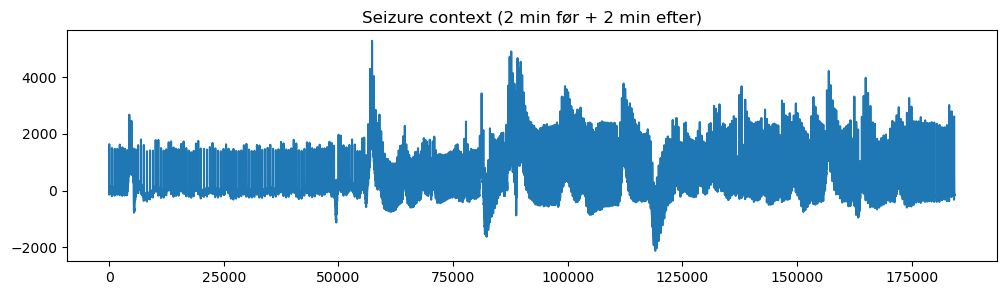

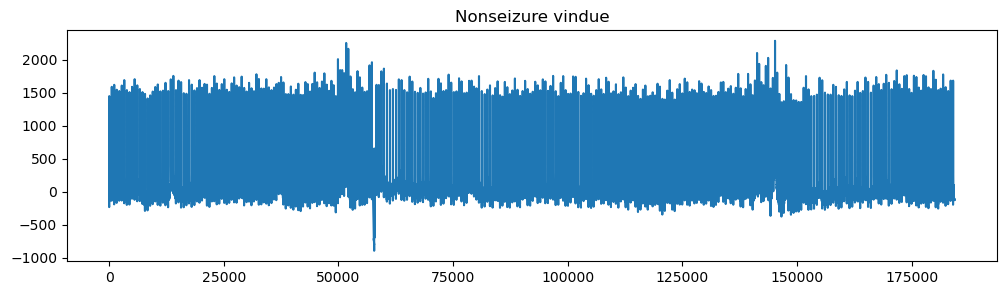

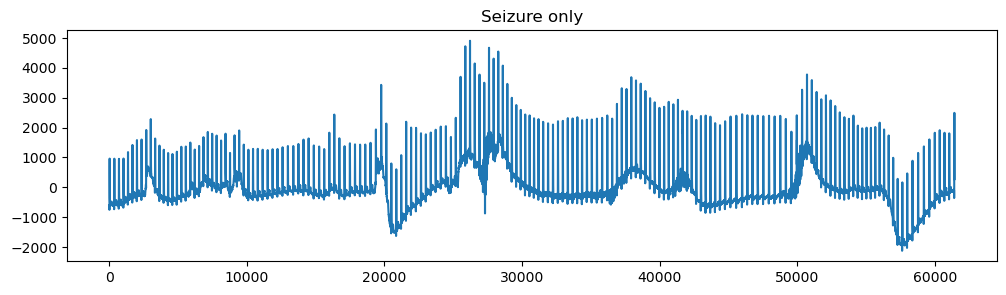

In [29]:
plt.figure(figsize=(12,3))
plt.plot(sig_seizure_ctx)
plt.title("Seizure context (2 min før + 2 min efter)")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(sig_nonseizure)
plt.title("Nonseizure vindue")
plt.show()

if sig_seizure_only is not None:
    plt.figure(figsize=(12,3))
    plt.plot(sig_seizure_only)
    plt.title("Seizure only")
    plt.show()


In [30]:
def basic_features(signal, fs):
    # slå om til numpy
    x = np.asarray(signal)
    feats = {}
    feats["len_samples"] = len(x)
    feats["duration_s"] = len(x) / fs
    feats["mean"] = float(np.mean(x))
    feats["std"] = float(np.std(x))
    feats["max"] = float(np.max(x))
    feats["min"] = float(np.min(x))
    # energi
    feats["rms"] = float(np.sqrt(np.mean(x**2)))
    return feats


In [31]:
fs = 1.0 / san_seizure_ctx.get("wf_increment_s", 1/512)  # fallback 512 Hz

rows = []
rows.append({"segment":"seizure_ctx", **basic_features(sig_seizure_ctx, fs)})
rows.append({"segment":"nonseizure", **basic_features(sig_nonseizure, fs)})
if sig_seizure_only is not None:
    rows.append({"segment":"seizure_only", **basic_features(sig_seizure_only, fs)})

feat_df = pd.DataFrame(rows)
feat_df


,segment,len_samples,duration_s,mean,std,max,min,rms
0,seizure_ctx,184320,360.0,9.403440,508.874158,5286.845594,-2126.036683,508.961033
1,nonseizure,184320,360.0,1.354641,228.289096,2285.868345,-894.230594,228.293115
2,seizure_only,61440,120.0,-30.688404,658.069581,4906.556466,-2126.036683,658.784754


In [32]:
def detect_r_peaks(signal, fs, threshold=None, refractory_ms=250):
    """
    Simple local-maximum based R-peak detector.
    - signal: 1D array
    - fs: sampling frequency (Hz)
    - threshold: amplitude threshold; if None use mean + 0.5*std
    - refractory_ms: minimum distance between peaks in ms
    Returns: numpy array of peak indices
    """
    x = np.asarray(signal)
    if threshold is None:
        threshold = np.mean(x) + 0.5 * np.std(x)

    ref_samples = max(1, int((refractory_ms / 1000.0) * fs))
    peaks = []
    last_peak = -ref_samples - 1
    N = len(x)
    # skip first and last sample to allow neighbor check
    for i in range(1, N - 1):
        if x[i] <= threshold:
            continue
        if x[i] > x[i - 1] and x[i] > x[i + 1]:
            if i - last_peak >= ref_samples:
                peaks.append(i)
                last_peak = i
    return np.array(peaks, dtype=int)


def rr_metrics_from_peaks(peak_idx, fs):
    """
    Compute RR metrics (ms) from peak indices.
    Returns dict: mean_rr_ms, sdnn_ms, rmssd_ms, pnn50_pct, n_peaks, n_rr
    """
    if peak_idx is None or len(peak_idx) < 2:
        return dict(mean_rr_ms=np.nan, sdnn_ms=np.nan, rmssd_ms=np.nan, pnn50_pct=np.nan,
                    n_peaks=len(peak_idx) if peak_idx is not None else 0, n_rr=0)

    times_ms = peak_idx / fs * 1000.0
    rr = np.diff(times_ms)  # ms
    n_rr = len(rr)
    mean_rr = float(np.mean(rr))
    sdnn = float(np.std(rr, ddof=1)) if n_rr > 1 else float(np.std(rr, ddof=0))
    # successive differences of RR (used for RMSSD and pNN50)
    diff_rr = np.diff(rr)
    rmssd = float(np.sqrt(np.mean(diff_rr ** 2))) if len(diff_rr) > 0 else np.nan
    pnn50 = 100.0 * np.sum(np.abs(diff_rr) > 50) / len(diff_rr) if len(diff_rr) > 0 else np.nan

    return dict(mean_rr_ms=mean_rr, sdnn_ms=sdnn, rmssd_ms=rmssd, pnn50_pct=pnn50,
                n_peaks=len(peak_idx), n_rr=n_rr)


# Compute metrics for the available segments
signals = {
    "seizure_ctx": sig_seizure_ctx,
    "nonseizure": sig_nonseizure,
}
if sig_seizure_only is not None:
    signals["seizure_only"] = sig_seizure_only

results = []
for name, sig in signals.items():
    peaks = detect_r_peaks(sig, fs=fs, threshold=None, refractory_ms=250)
    metrics = rr_metrics_from_peaks(peaks, fs=fs)
    results.append({"segment": name, **metrics})

rr_df = pd.DataFrame(results).set_index("segment")
rr_df

,mean_rr_ms,sdnn_ms,rmssd_ms,pnn50_pct,n_peaks,n_rr
segment,,,,,,
seizure_ctx,661.276425,335.849584,239.481909,28.913444,545,544
nonseizure,693.672327,344.705355,508.309779,83.365571,519,518
seizure_only,547.472531,253.409989,209.240312,20.642202,220,219
